In [9]:
pip install opencv-python scikit-learn matplotlib pillow tqdm

Note: you may need to restart the kernel to use updated packages.


In [10]:
import os
import cv2
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

DATASET_PATH = "/kaggle/input/image-retrivel/UCMerced_LandUse/Images"
IMAGE_SIZE = (128, 128)

images = []
labels = []
class_names = sorted(os.listdir(DATASET_PATH))

for class_name in class_names:
    class_folder = os.path.join(DATASET_PATH, class_name)
    for image_file in os.listdir(class_folder):
        img_path = os.path.join(class_folder, image_file)
        img = cv2.imread(img_path)
        img = cv2.resize(img, IMAGE_SIZE)
        images.append(img)
        labels.append(class_name)

images = np.array(images)
labels = np.array(labels)

print(f"Loaded {len(images)} images with shape: {images[0].shape}")

Loaded 2100 images with shape: (128, 128, 3)


In [11]:
from skimage.feature import local_binary_pattern

def extract_features(image):
    # Color histogram
    chans = cv2.split(image)
    color_hist = np.concatenate([
        cv2.calcHist([ch], [0], None, [32], [0, 256]).flatten()
        for ch in chans
    ])

    # Texture (LBP)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    lbp = local_binary_pattern(gray, P=8, R=1, method="uniform")
    lbp_hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, 10), density=True)

    return np.concatenate([color_hist, lbp_hist])

features = np.array([extract_features(img) for img in tqdm(images)])
print("✅ Features shape:", features.shape)


100%|██████████| 2100/2100 [00:07<00:00, 272.30it/s]

✅ Features shape: (2100, 105)


In [12]:
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

scaler = MinMaxScaler()
features_scaled = scaler.fit_transform(features)

le = LabelEncoder()
labels_encoded = le.fit_transform(labels)


In [13]:
def evaluate_particle(position, features, labels):
    mask = position > 0.5
    if np.sum(mask) == 0:
        return 0.0
    X_sel = features[:, mask]
    X_train, X_test, y_train, y_test = train_test_split(X_sel, labels, test_size=0.3, stratify=labels)
    clf = KNeighborsClassifier(n_neighbors=3)
    clf.fit(X_train, y_train)
    acc = accuracy_score(y_test, clf.predict(X_test))
    return acc


In [14]:
def particle_swarm_optimization(features, labels, n_particles=20, max_iter=20, w=0.7, c1=1.5, c2=1.5):
    n_features = features.shape[1]
    
    # Initialize particles
    particles = np.random.rand(n_particles, n_features)
    velocities = np.random.rand(n_particles, n_features) * 0.1
    
    # Initialize personal and global bests
    pbest_positions = particles.copy()
    pbest_scores = np.array([evaluate_particle(p, features, labels) for p in particles])
    
    gbest_idx = np.argmax(pbest_scores)
    gbest_position = pbest_positions[gbest_idx].copy()
    gbest_score = pbest_scores[gbest_idx]
    
    # Start optimization
    for t in range(max_iter):
        for i in range(n_particles):
            r1 = np.random.rand(n_features)
            r2 = np.random.rand(n_features)
            
            velocities[i] = (
                w * velocities[i] +
                c1 * r1 * (pbest_positions[i] - particles[i]) +
                c2 * r2 * (gbest_position - particles[i])
            )
            
            particles[i] += velocities[i]
            particles[i] = np.clip(particles[i], 0, 1)
            
            score = evaluate_particle(particles[i], features, labels)
            if score > pbest_scores[i]:
                pbest_scores[i] = score
                pbest_positions[i] = particles[i].copy()
                
                if score > gbest_score:
                    gbest_score = score
                    gbest_position = particles[i].copy()
        
        print(f"Iteration {t+1} | Best Accuracy: {gbest_score:.4f}")
    
    return gbest_position, gbest_score


In [15]:
best_position, best_accuracy = particle_swarm_optimization(features_scaled, labels_encoded)
selected_features = features_scaled[:, best_position > 0.5]

print(f"\n✅ Final Accuracy (Best Particle): {best_accuracy:.4f}")
print(f"✅ Selected {np.sum(best_position > 0.5)} features out of {features.shape[1]}")


Iteration 1 | Best Accuracy: 0.6635
Iteration 2 | Best Accuracy: 0.6635
Iteration 3 | Best Accuracy: 0.6635
Iteration 4 | Best Accuracy: 0.6794
Iteration 5 | Best Accuracy: 0.6794
Iteration 6 | Best Accuracy: 0.6794
Iteration 7 | Best Accuracy: 0.6794
Iteration 8 | Best Accuracy: 0.6794
Iteration 9 | Best Accuracy: 0.6794
Iteration 10 | Best Accuracy: 0.6794
Iteration 11 | Best Accuracy: 0.6794
Iteration 12 | Best Accuracy: 0.6794
Iteration 13 | Best Accuracy: 0.6794
Iteration 14 | Best Accuracy: 0.6794
Iteration 15 | Best Accuracy: 0.6794
Iteration 16 | Best Accuracy: 0.6794
Iteration 17 | Best Accuracy: 0.6794
Iteration 18 | Best Accuracy: 0.6794
Iteration 19 | Best Accuracy: 0.6794
Iteration 20 | Best Accuracy: 0.6794

✅ Final Accuracy (Best Particle): 0.6794
✅ Selected 61 features out of 105


In [16]:
from sklearn.metrics import classification_report

X_train, X_test, y_train, y_test = train_test_split(selected_features, labels_encoded, test_size=0.3)
clf = KNeighborsClassifier(n_neighbors=3)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred, target_names=le.classes_))


                   precision    recall  f1-score   support

     agricultural       0.92      0.89      0.90        37
         airplane       0.46      0.85      0.60        20
  baseballdiamond       0.58      0.35      0.44        20
            beach       0.86      0.73      0.79        33
        buildings       0.43      0.51      0.47        35
        chaparral       0.85      0.93      0.89        30
 denseresidential       0.55      0.57      0.56        30
           forest       0.59      0.79      0.68        29
          freeway       0.70      0.66      0.68        32
       golfcourse       0.88      0.72      0.79        32
           harbor       0.97      0.97      0.97        31
     intersection       0.32      0.60      0.42        20
mediumresidential       0.51      0.81      0.63        27
   mobilehomepark       0.66      0.89      0.76        28
         overpass       0.71      0.66      0.68        38
       parkinglot       0.60      0.52      0.56       

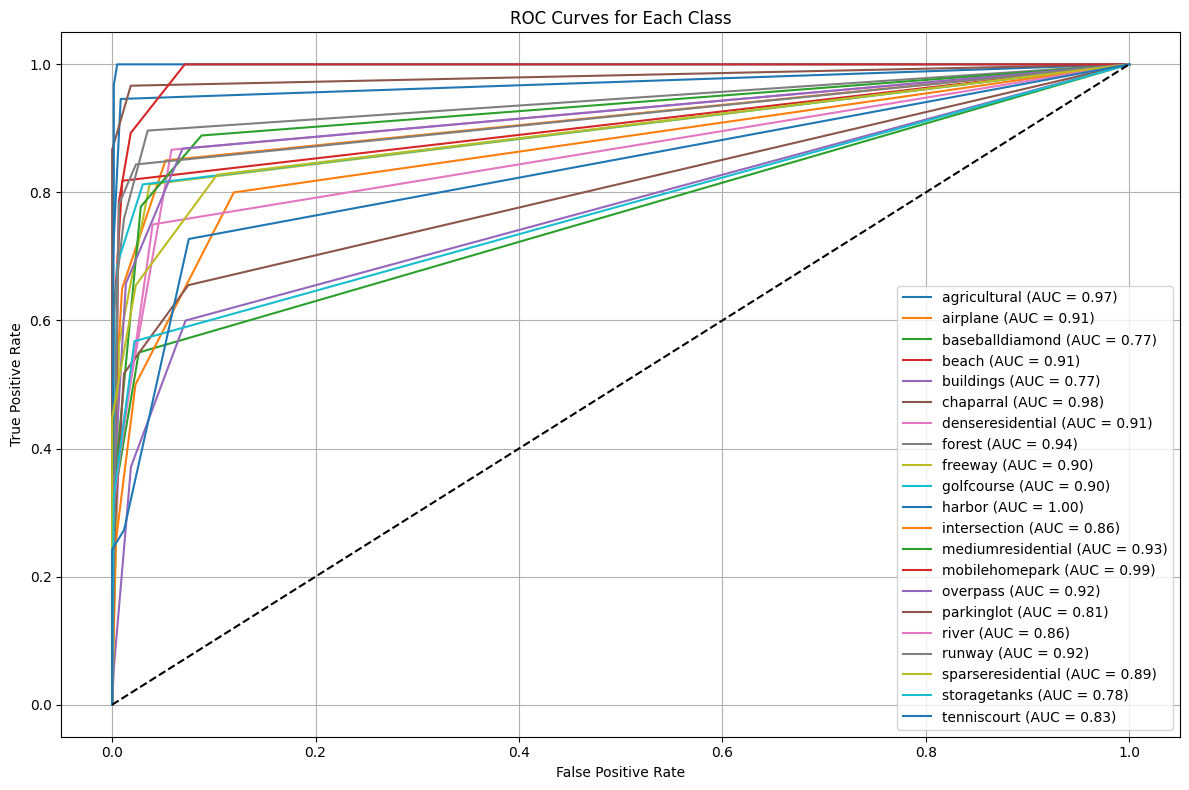

In [17]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# Binarize the output labels for multi-class AUC
y_test_bin = label_binarize(y_test, classes=np.unique(labels_encoded))
y_pred_prob = clf.predict_proba(X_test)

# Number of classes
n_classes = y_test_bin.shape[1]

# Plot setup
plt.figure(figsize=(12, 8))

for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{le.classes_[i]} (AUC = {roc_auc:.2f})')

# Plot ROC curve for each class
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for Each Class")
plt.legend(loc='lower right')
plt.grid()
plt.tight_layout()
plt.show()


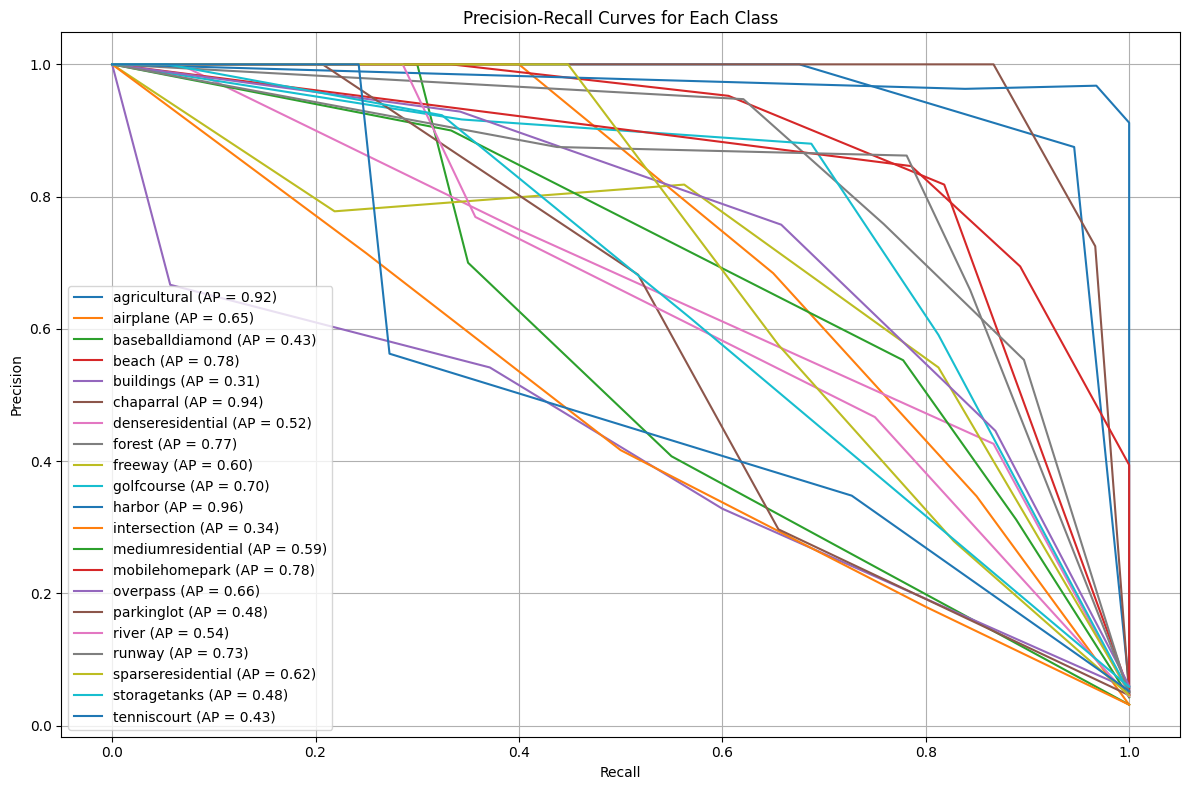

In [18]:
from sklearn.metrics import precision_recall_curve, average_precision_score

# Plot setup
plt.figure(figsize=(12, 8))

for i in range(n_classes):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_pred_prob[:, i])
    avg_precision = average_precision_score(y_test_bin[:, i], y_pred_prob[:, i])
    plt.plot(recall, precision, label=f'{le.classes_[i]} (AP = {avg_precision:.2f})')

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curves for Each Class")
plt.legend(loc='lower left')
plt.grid()
plt.tight_layout()
plt.show()


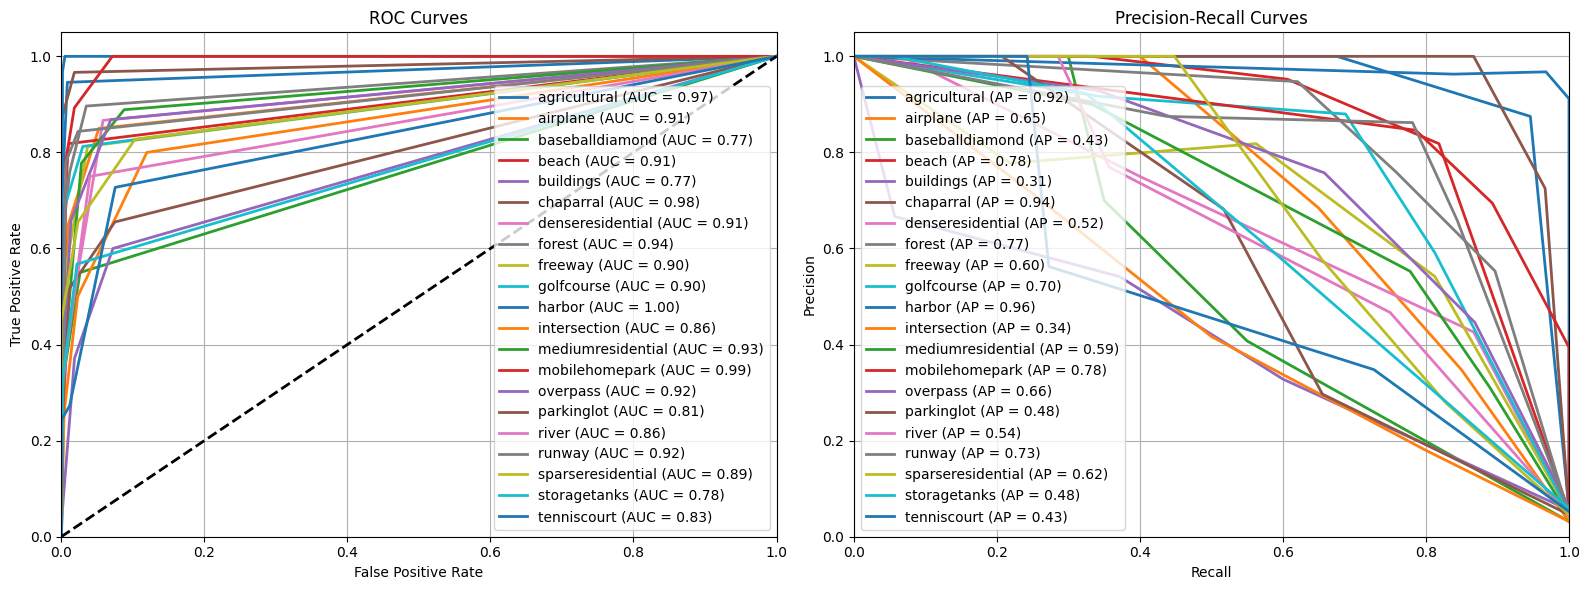

In [19]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# ROC Curve Plot
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    axes[0].plot(fpr, tpr, lw=2, label=f'{le.classes_[i]} (AUC = {roc_auc:.2f})')

axes[0].plot([0, 1], [0, 1], 'k--', lw=2)
axes[0].set_xlim([0.0, 1.0])
axes[0].set_ylim([0.0, 1.05])
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('ROC Curves')
axes[0].legend(loc="lower right")
axes[0].grid()

# Precision-Recall Curve Plot
for i in range(n_classes):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_pred_prob[:, i])
    ap = average_precision_score(y_test_bin[:, i], y_pred_prob[:, i])
    axes[1].plot(recall, precision, lw=2, label=f'{le.classes_[i]} (AP = {ap:.2f})')

axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('Recall')
axes[1].set_ylabel('Precision')
axes[1].set_title('Precision-Recall Curves')
axes[1].legend(loc="lower left")
axes[1].grid()

plt.tight_layout()
plt.show()


<Figure size 800x600 with 0 Axes>

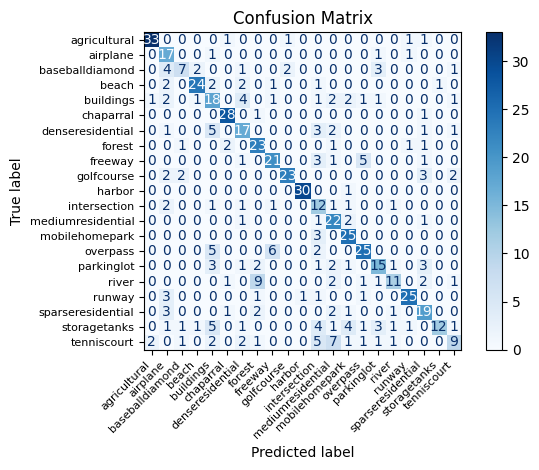

In [20]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
disp.plot(cmap='Blues')
plt.xticks(rotation=45, ha='right')
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()


In [21]:
from sklearn.metrics import classification_report

report = classification_report(y_test, y_pred, target_names=class_names, output_dict=True)

# Display full report
import pandas as pd

report_df = pd.DataFrame(report).transpose()
print(report_df)

# Find class with highest accuracy (f1-score used as proxy)
sorted_f1 = report_df.iloc[:-3].sort_values(by="f1-score", ascending=False)  # Ignore 'accuracy', 'macro avg', 'weighted avg'

top_class = sorted_f1.head(1)
print("\n Class with highest F1-score:")
print(top_class)


                   precision    recall  f1-score     support
agricultural        0.916667  0.891892  0.904110   37.000000
airplane            0.459459  0.850000  0.596491   20.000000
baseballdiamond     0.583333  0.350000  0.437500   20.000000
beach               0.857143  0.727273  0.786885   33.000000
buildings           0.428571  0.514286  0.467532   35.000000
chaparral           0.848485  0.933333  0.888889   30.000000
denseresidential    0.548387  0.566667  0.557377   30.000000
forest              0.589744  0.793103  0.676471   29.000000
freeway             0.700000  0.656250  0.677419   32.000000
golfcourse          0.884615  0.718750  0.793103   32.000000
harbor              0.967742  0.967742  0.967742   31.000000
intersection        0.324324  0.600000  0.421053   20.000000
mediumresidential   0.511628  0.814815  0.628571   27.000000
mobilehomepark      0.657895  0.892857  0.757576   28.000000
overpass            0.714286  0.657895  0.684932   38.000000
parkinglot          0.60

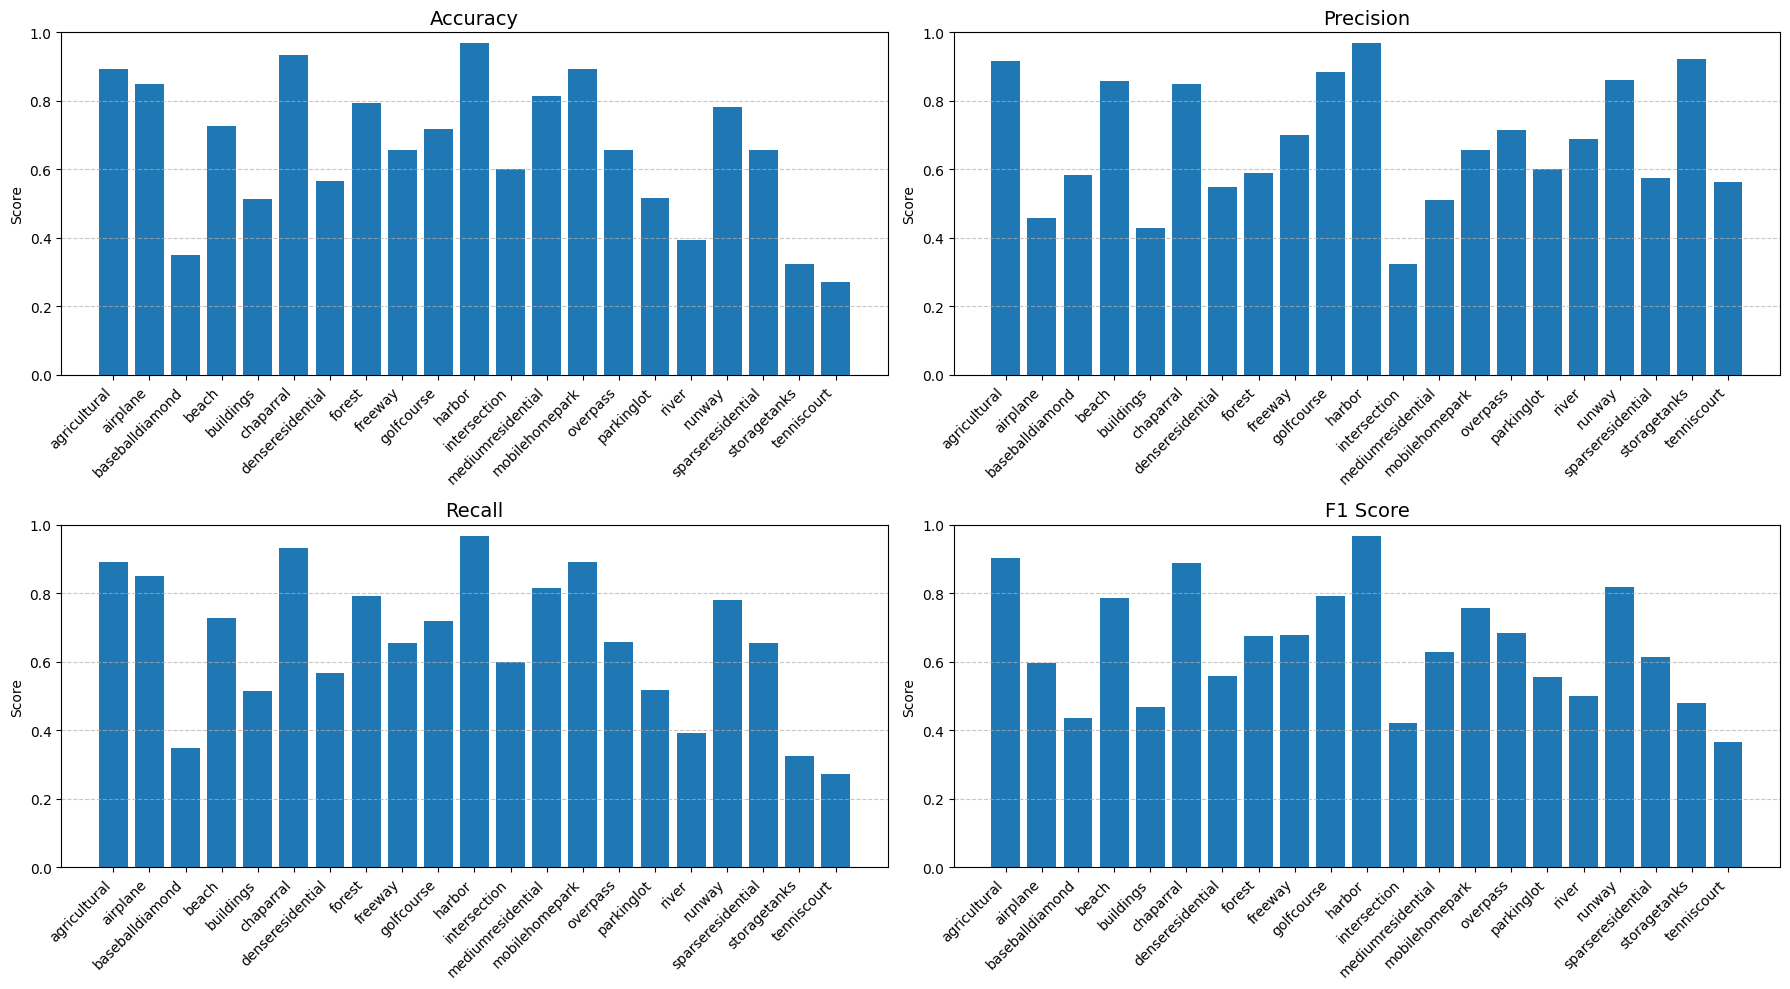

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Ensure y_test and y_pred are numpy arrays
y_test = np.array(y_test)
y_pred = np.array(y_pred)

# Number of classes
num_classes = len(class_names)

# Calculate per-class metrics
precision = precision_score(y_test, y_pred, average=None)
recall = recall_score(y_test, y_pred, average=None)
f1 = f1_score(y_test, y_pred, average=None)

# Accuracy per class = correct predictions / total samples of that class
accuracy = []
for i in range(num_classes):
    idx = y_test == i
    acc = np.sum(y_pred[idx] == i) / np.sum(idx)
    accuracy.append(acc)
accuracy = np.array(accuracy)

# Plotting
metrics = [accuracy, precision, recall, f1]
metric_names = ['Accuracy', 'Precision', 'Recall', 'F1 Score']

fig, axes = plt.subplots(2, 2, figsize=(18, 10))
axes = axes.flatten()

for i, ax in enumerate(axes):
    ax.bar(class_names, metrics[i])
    ax.set_title(metric_names[i], fontsize=14)
    ax.set_ylabel("Score")
    ax.set_xticks(range(len(class_names)))
    ax.set_xticklabels(class_names, rotation=45, ha='right')
    ax.set_ylim(0, 1)
    ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()
